### Caclulate S&P 500 YTD Performance as Benchmark

#### Creating Function to Pull Historical Daily Prices for Specific Ticker and Date Range

In [118]:
#used this source as reference : https://medium.com/codex/creating-a-diversified-portfolio-with-correlation-matrix-in-python-7d7825255a2d
def historical_daily(ticker, start_date, end_date):
    #alpha vantage API request for daily adjusted prices
    token = alpha_auth_key
    url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&outputsize=full&symbol={ticker}&interval=5min&apikey={token}&datatype=csv'
    r = requests.get(url)

    #converting from bytes to pandas dataframe : https://stackoverflow.com/questions/47379476/how-to-convert-bytes-data-into-a-python-pandas-dataframe
    df_daily = pd.read_csv(BytesIO(r.content))
    
    #setting index 
    df_daily.set_index('timestamp', inplace=True)
    df_daily = df_daily[df_daily.index >= start_date]
    df_daily = df_daily[df_daily.index <= end_date]
    df_daily.index = pd.to_datetime(df_daily.index)
    return df_daily

#### Using Function to Create and Store SPY 2021 YTD Data

In [119]:
sp_500 = historical_daily('SPY', '2021-01-01', '2021-12-07')

In [196]:
sp_500.head(1)

,timestamp,open,high,low,close,adjusted_close,volume,dividend_amount,split_coefficient
0,2021-12-07,464.41,468.88,458.6546,468.28,468.28,95484688,0.0,1.0


In [218]:
sp_500 = sp_500.sort_values(by=['timestamp']).reset_index()
sp_500.drop(columns='index', inplace=True)

In [223]:
sp_500.to_csv('spy_daily_2021.csv')

In [49]:
sp_500 = pd.read_csv('spy_daily_2021.csv')

In [4]:
sp_500.head()

,Unnamed: 0,timestamp,open,high,low,close,adjusted_close,volume,dividend_amount,split_coefficient
0,0,2021-01-04,375.31,375.45,364.82,368.79,365.187629,110210810,0.0,1.0
1,1,2021-01-05,368.10,372.50,368.05,371.33,367.702818,66426229,0.0,1.0
2,2,2021-01-06,369.71,376.98,369.12,373.55,369.901133,107997675,0.0,1.0
3,3,2021-01-07,376.10,379.90,375.91,379.10,375.396920,68766812,0.0,1.0
4,4,2021-01-08,380.59,381.49,377.10,381.26,377.535821,71677208,0.0,1.0


#### Series for Cumulative SPY YTD Returns 2021

In [50]:
#cumulative YTD returns for SPY index. Takes each adjusted close divided by first day of the year's close
sp_returns_2021 = sp_500['adjusted_close'] / sp_500['adjusted_close'].iloc[0]
(sp_500['adjusted_close'] / sp_500['adjusted_close'].iloc[0])[:10]

0    1.000000
1    1.006887
2    1.012907
3    1.027956
4    1.033813
5    1.026845
6    1.027061
7    1.029827
8    1.026221
9    1.018737
Name: adjusted_close, dtype: float64

In [136]:
#sp_returns, sp_returns.name = sp_500['adjusted_close'].iloc[0] / sp_500['adjusted_close'], 'spy'

#### Cleaning/Feautre Engineering - Returns & Moving Averages

In [51]:
sp_500['cum_return'] = sp_returns_2021
sp_500.drop(columns=['Unnamed: 0', 'dividend_amount', 'split_coefficient'], inplace=True)
sp_500.set_index('timestamp', inplace=True)
allocation = 100_000
sp_500['position'] = allocation * sp_500['cum_return']
sp_500['MA10'] = sp_500['adjusted_close'].rolling(10).mean()
sp_500['MA20'] = sp_500['adjusted_close'].rolling(20).mean()
sp_500.to_csv('sp_2021_cum_returns.csv')

In [59]:
sp_500.tail()

,open,high,low,close,adjusted_close,volume,cum_return,position,MA10,MA20
timestamp,,,,,,,,,,
2021-12-01,461.64,464.67,450.2900,450.50,450.50,132485835,1.233612,123361.243330,464.159,465.4715
2021-12-02,450.73,459.07,450.3100,457.40,457.40,127637758,1.252507,125250.683017,463.085,465.1055
2021-12-03,459.17,460.30,448.9200,453.42,453.42,137331647,1.241608,124160.832299,461.454,464.4310
2021-12-06,456.13,460.79,453.5600,458.79,458.79,98977532,1.256313,125631.309273,460.444,463.9440
2021-12-07,464.41,468.88,458.6546,468.28,468.28,95484688,1.282300,128229.973422,460.515,463.9115


#### Visualizing SPY 2021 YTD Performance

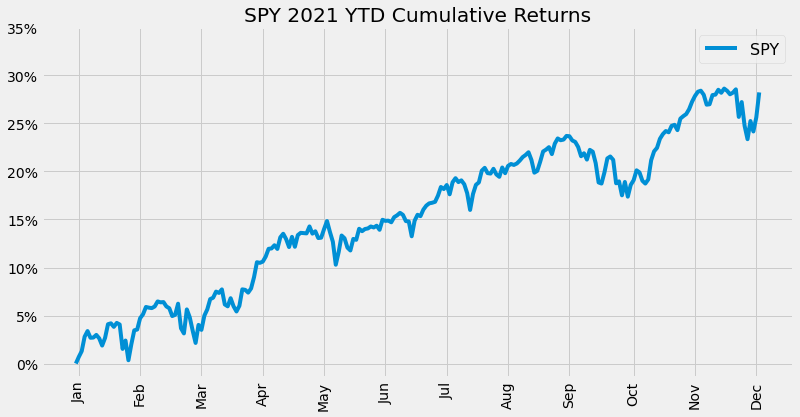

In [222]:
plt.figure(figsize=(12,6))
plt.plot(sp_returns_2021, label = 'SPY')
plt.legend(fontsize = 16)
plt.title('SPY 2021 YTD Cumulative Returns')

#average number of trading days in a month is 21
days = [1,22,43,64,85,106,127,
                 148,169,191,212,233]
#create list of all the months in the year
months = ['Jan','Feb','Mar','Apr','May','Jun',
               'Jul','Aug','Sep','Oct','Nov','Dec'] 
#recreate return % for more legible yticks 
returns = [1, 1.05, 1.10, 1.15, 1.20, 1.25, 1.3, 1.35]
returns_percent = ['0%', '5%', '10%', '15%', '20%', '25%', '30%', '35%']
#label xticks as months of the year 
plt.xticks(days, months, rotation='vertical')
#label yticks as percentages
plt.yticks(returns, returns_percent)

plt.show();

In [305]:
sp_500_rets_df = pd.read_csv('sp_2021_cum_returns.csv')

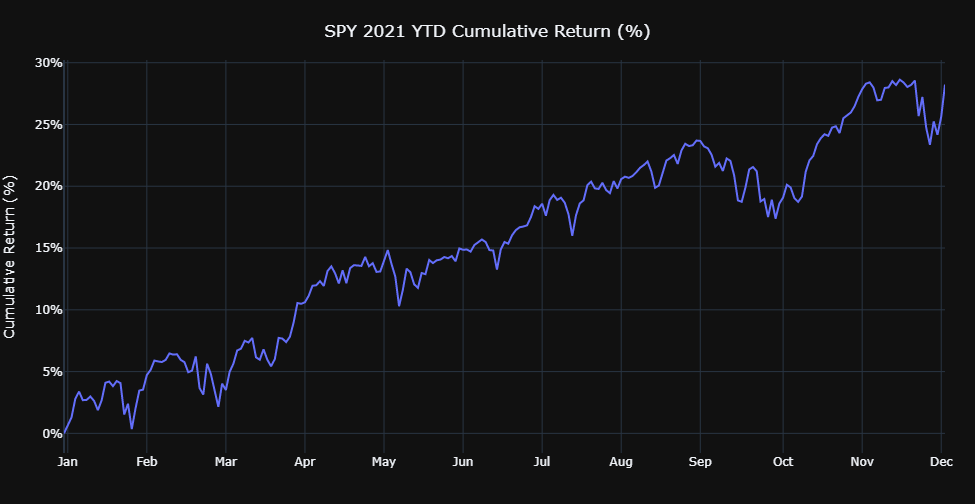

In [243]:
start_date = '2021-01-01'
end_date = '2021-11-01'
import plotly.express as px
import plotly.graph_objects as go
ticker = 'SPY'
df = sp_500_rets_df
fig = px.line(
    df, x=sp_500_rets_df.index, y='cum_return', 
    labels={
        'index': "", 'cum_return': 'Cumulative Return (%)'})
               
fig.update_layout(
    title={
        'text': f'{ticker} 2021 YTD Cumulative Return (%)', 'y':0.95, 'x':0.5,
        'xanchor': 'center', 'yanchor': 'top'}, 
    xaxis = dict(
        tickmode = 'array',
        tickvals = [1,22,43,64,85,106,127, 148,169,191,212,233],
        ticktext = ['Jan','Feb','Mar','Apr','May','Jun',
                    'Jul','Aug','Sep','Oct','Nov','Dec']),       
    yaxis = dict(
        tickmode = 'array',
        tickvals = [1, 1.05, 1.10, 1.15, 1.20, 1.25, 1.3, 1.35],
        ticktext = ['0%', '5%', '10%', '15%', '20%', '25%', '30%', '35%']))

fig.update_layout(
    height=500, width=800, showlegend=False, 
    xaxis_rangeslider_visible=False)

fig.update_layout(margin=go.layout.Margin(
    l=30,r=30, b=10, t=60),
    paper_bgcolor=None, template='plotly_dark')

fig.show()

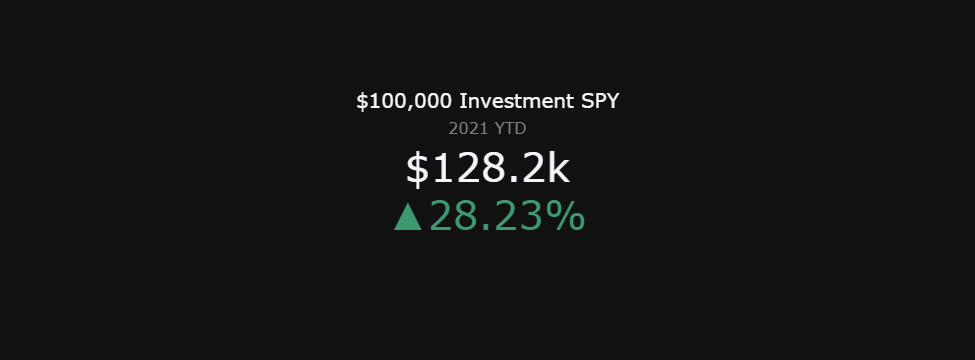

In [162]:
fig = go.Figure()

fig.add_trace(go.Indicator(
    align = 'center', mode = "number+delta", value = 128_229,
    title = {
        "text": "$100,000 Investment SPY<br><span style='font-size:0.8em;color:gray'>2021 YTD</span><br><span style='font-size:0.8em;color:gray'>",
        'font':{
        'size':20}},
    delta = {
        'reference': 100_000, 'relative': True, 'valueformat':'.2%',
        'font':{
        'size':40}},
    number = {
        'prefix': "$", 
        'font':{
        'size':40}},
    domain = {
        'x': [0, 0], 'y': [0, 0]}))

fig.update_layout(
    paper_bgcolor=None, height=300, width=300, template='plotly_dark')

fig.show()

In [60]:
from plotly.subplots import make_subplots

In [104]:
#tried different templates, plotly_dark looks good for financial data. Charts stick out
import plotly.io as pio
pio.templates

Templates configuration
-----------------------
    Default template: 'plotly'
    Available templates:
        ['ggplot2', 'seaborn', 'simple_white', 'plotly',
         'plotly_white', 'plotly_dark', 'presentation', 'xgridoff',
         'ygridoff', 'gridon', 'none']

In [309]:
sp_500_final.head(1)

,timestamp,open,high,low,close,adjusted_close,volume,cum_return,position,MA10,MA20,RSI_14,RSI_14_A_70,RSI_14_B_30
0,2021-01-04,375.31,375.45,364.82,368.79,365.187629,110210810.0,1.0,100000.0,NaN,NaN,NaN,NaN,NaN


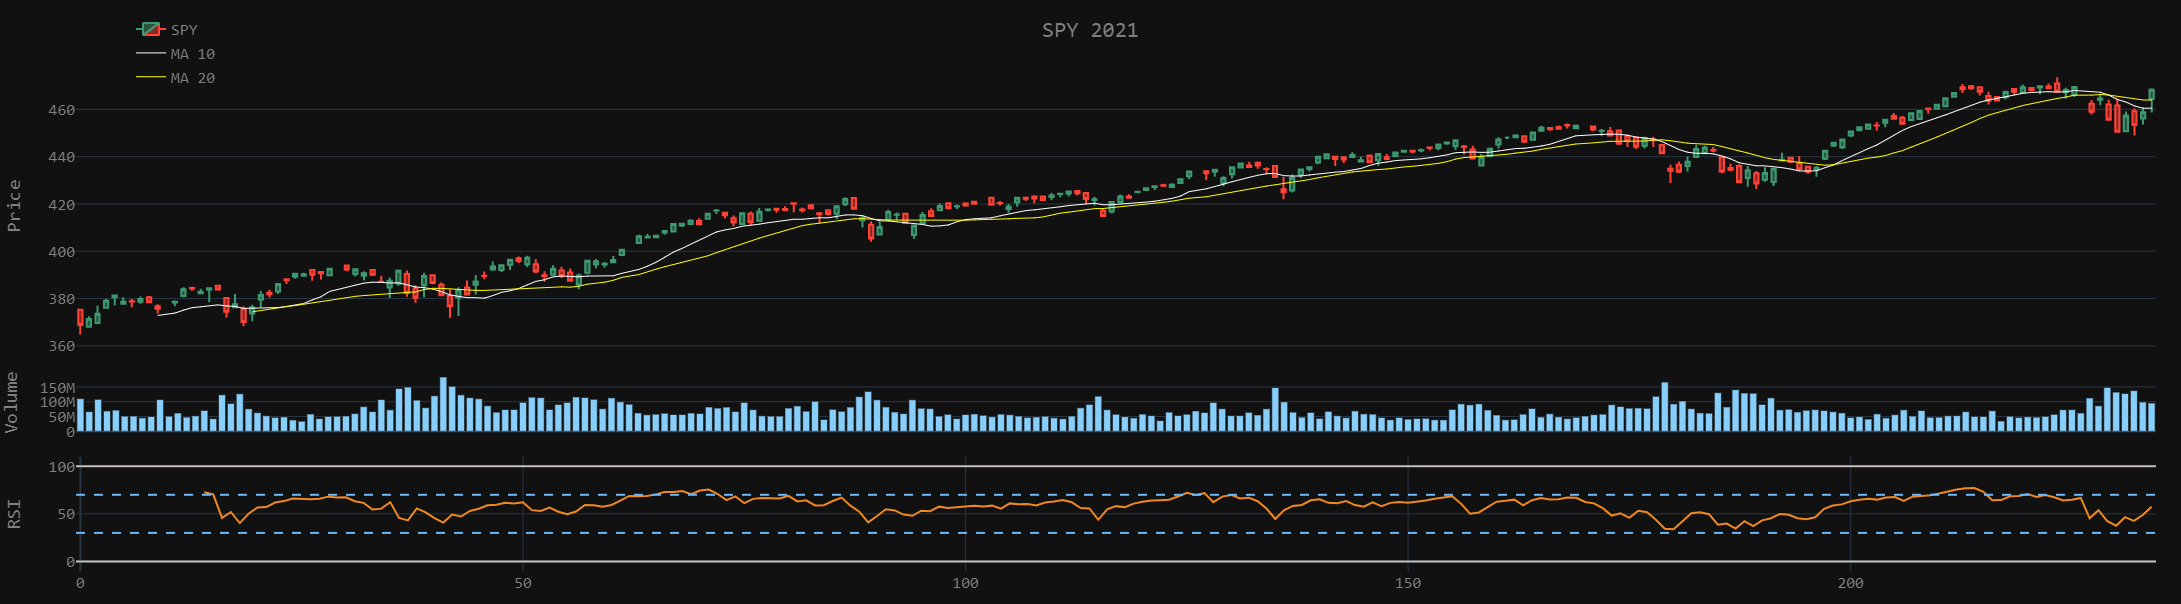

In [338]:
#used these site as resources : https://python.plainenglish.io/a-simple-guide-to-plotly-for-plotting-financial-chart-54986c996682 
#                               https://www.alpharithms.com/relative-strength-index-rsi-in-python-470209/
#instantiating a plotly subplot
fig = make_subplots(rows=3, cols=1, shared_xaxes=True, 
                    vertical_spacing=0.05, 
                    row_heights=[0.25,0.05,0.1],)
#adding candlestick chart                   
fig.add_trace(go.Candlestick(
    x=sp_500_rets_df['timestamp'], open=sp_500_rets_df['open'],
    high=sp_500_rets_df['high'], low=sp_500_rets_df['low'],
    close=sp_500_rets_df['close'], name=f'{ticker}'), row=1, col=1)
#adding Moving Average 10day line
fig.add_trace(go.Scatter(
    x=sp_500_rets_df['timestamp'], y=sp_500_rets_df['MA10'], 
    line=dict(color='white', width=1), name='MA 10'))
#adding Moving Average 20day line                
fig.add_trace(go.Scatter(
    x=sp_500_rets_df['timestamp'], y=sp_500_rets_df['MA20'], 
    line=dict(color='yellow', width=1),name='MA 20'))
#adding volume indicator
fig.add_trace(go.Bar(
    x=sp_500_rets_df.index, y=sp_500_rets_df['volume'],
    marker_color = 'LightSkyBlue', showlegend=False, name='Volume'), row=2, col=1)
#adding RSI indicator 
fig.add_trace(go.Scatter(
    x=sp_500_final.index, y=sp_500_final['RSI_14'],
    line=dict(color='#EF8820', width=2), showlegend=False, name='RSI-14'), row=3, col=1)

#setting RSI range from 0-100 as standard practice for this indicator
fig.update_yaxes(range=[-10, 110], row=3, col=1)
fig.add_hline(y=0, col=1, row=3, line_color="#C3BEB9", line_width=2)
fig.add_hline(y=100, col=1, row=3, line_color="#C3BEB9", line_width=2)
#adding overbought/oversold lines for RSI 30/70 levels
fig.add_hline(y=30, col=1, row=3, line_color='#6EB7F8', line_width=2, line_dash='dash')
fig.add_hline(y=70, col=1, row=3, line_color='#6EB7F8', line_width=2, line_dash='dash')


fig.update_layout(
    title={
        'text': f"{ticker} 2021",
        'y':0.965, 'x':0.5, 'xanchor': 'center', 'yanchor': 'top'},
    legend=dict(
        yanchor="top",
        y=1.1,
        xanchor="left",
        x=0.0265),
    font=dict(
        family="Gotham Narrow, monospace",
        size=16,
        color="#7f7f7f"))


fig.update_layout(
    height=600, width=1000, showlegend=True, 
    xaxis_rangeslider_visible=False, template='plotly_dark')
  
fig.update_xaxes(rangebreaks=[dict(bounds=["sat", "mon"])])   #removes gaps in data by removing weekends(non, trading days)
fig.update_yaxes(title_text="Price", row=1, col=1)
fig.update_yaxes(title_text="Volume", row=2, col=1)
fig.update_yaxes(title_text="RSI", row=3, col=1)
fig.update_layout(
    margin=go.layout.Margin(
    l=60, r=25, b=30, t=60), paper_bgcolor=None,
    xaxis = dict(
        tickmode = 'array',
        tickvals = [1,22,43,64,85,106,127, 148,169,191,212,233],
        ticktext = ['Jan','Feb','Mar','Apr','May','Jun',
                    'Jul','Aug','Sep','Oct','Nov','Dec']))

fig.show()

In [261]:
import pandas_ta as ta

In [306]:
sp_500_rsi = sp_500_rets_df.ta.rsi(close='adjusted_close', length=14, signal_indicators=True, xa=70, xb=30)
# kept getting errors when trying merge, used this solution : https://stackoverflow.com/questions/47655296/pandas-merge-two-datasets-with-same-number-of-rows
spy_final_2021 = pd.concat([sp_500_rets_df.reset_index(drop=True),sp_500_rsi.reset_index(drop=True)], axis=1)
spy_final_2021.to_csv('spy_final_2021.csv')

### Function to Plot Cumulative Returns for Two or More Tickers

In [ ]:
def ticker_comp(ticker1, ticker2, start_date, end_date):
    

### Function to Plot Two Tickers 

### Plotting WSB Portfolio Return YTD 

#### Show Return, Volatility, and Sharpe Ratio